## Loading packages


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scanpy as sc
import squidpy as sq
import scipy.sparse as sp
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, argrelextrema
from scipy.sparse import issparse, csr_matrix
from diptest import diptest
import statsmodels.api as sm
from shapely.geometry import Point, Polygon, MultiPoint
from scipy.spatial import ConvexHull
import sys
sys.path.append('/Users/rasools/Library/CloudStorage/OneDrive-Chalmers/Documents/github/ELIXIR-SCO-spatial-transcriptomics/day_1/practical_1/custom')
import tenx_method_nb_helper_functions as hf

## Loading data and primary inspections



Making adata object considering the transcripts that should be used for the analysis.
Running analysis on the transcripts that are only in the nucleus. 

In [2]:
sample_path = "/Users/rasools/Library/CloudStorage/OneDrive-Chalmers/Documents/github/ELIXIR-SCO-spatial-transcriptomics/day_1/practical_1/data/xenium_2.0.0_io"
transcripts_csv_path = os.path.join(sample_path, "transcripts.csv")
transcripts_df = pd.read_csv(transcripts_csv_path)
nucleus_boundaries_gz_path = os.path.join(sample_path, "nucleus_boundaries.csv.gz")
nucleus_df = pd.read_csv(nucleus_boundaries_gz_path, compression='gzip')

### Making the adata object

In [3]:
adata = hf.create_adata(sample_path, nucleus_genes_only = False)
adata

AnnData object with n_obs × n_vars = 162254 × 377
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

The `AnnData` object, `adata`, contains a structured dataset with cells as observations (`n_obs = 162254`) and genes as variables (`n_vars = 377`). Here's a breakdown of the main components within `adata`:

`obs` (Observations): This table contains metadata about each cell, where each row corresponds to a cell, and each column holds information about a specific attribute:

- `cell_id`: Unique identifier for each cell.
  
- `x_centroid` and `y_centroid`: Coordinates of each cell’s center in the spatial layout, indicating where each cell is located within the tissue.
  
- `transcript_counts`: Total transcript counts for each cell, showing the overall gene expression level.
- `control_probe_counts` and `control_codeword_counts`: Counts related to control probes and codewords, which are often used for quality control in spatial transcriptomics.
- `unassigned_codeword_counts` and `deprecated_codeword_counts`: Counts of unassigned or deprecated codewords, indicating low-confidence or outdated identifiers.
- `total_counts`: Total counts across all measured attributes, representing the cell’s total signal.
- `cell_area` and `nucleus_area`: Physical measurements of the cell and its nucleus area, in pixels or micrometers.
 
`var` (Variables): This table contains metadata about each gene, where each row is a gene and each column is an attribute:

- `gene_ids`: Unique identifiers for each gene, often in Ensembl or another standardized format.
  
- `feature_types`: Type of feature associated with each gene, such as "gene" or "transcript."
  
- `genome`: Information about the genome source of each gene, like "human" or "mouse."

`obsm` (Multi-dimensional Observations): This slot contains multi-dimensional data related to cells. Here, `spatial` stores spatial coordinates for each cell, allowing visualization and spatial analysis of cells in their tissue context.

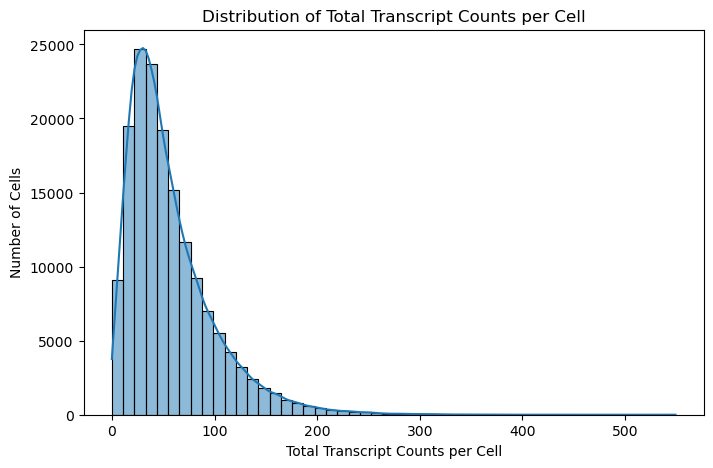

In [4]:
adata.obs['total_counts'] = adata.X.sum(axis=1)
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['total_counts'], kde=True, bins=50)
plt.xlabel("Total Transcript Counts per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Transcript Counts per Cell")
plt.show()

We calculate the total transcript counts for each cell by summing gene expression values across all genes and the number of genes detected in each cell. The resulting distributions gives us an overview of the data quality and cellular diversity in terms of RNA content.

These provide a measure of each cell's transcriptional activity or RNA content. High total counts typically indicate cells with higher transcriptional activity, while very low total counts may suggest low-quality cells or empty spots with minimal RNA.
Examining this distribution helps us assess data quality and identify potential outliers:

- Cells with Very Low Counts: These may represent low-quality cells or background noise, which could be filtered out in subsequent steps to improve analysis accuracy.
- Cells with Very High Counts: High total counts may indicate cell types with naturally high transcriptional activity or potential doublets (two cells counted as one).

This plot provides a quick check of the dataset’s quality and helps inform any initial filtering steps. A typical goal is to ensure the data has a reasonable distribution of RNA counts per cell, without excessive noise or artifacts that might skew downstream analysis.



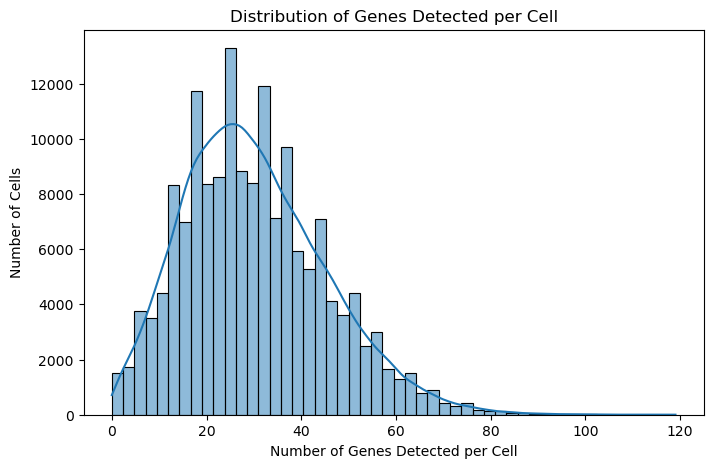

In [5]:
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['n_genes'], kde=True, bins=50)
plt.xlabel("Number of Genes Detected per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Genes Detected per Cell")
plt.show()

Now lets find genes with the highest expression across the whole dataset. We calculate the mean expression level of each gene across all cells and identify the top 10 most highly expressed genes, then plot them to understand which genes dominate the transcriptional landscape. This helps us quickly identify genes with the highest abundance, which are often either essential housekeeping genes or specific markers that define particular cell types. Examining the top expressed genes serves both technical and biological purposes: it allows us to check for any potential technical artifacts (e.g., genes with unusually high background expression) and offers biological insight by highlighting key genes likely involved in core cellular functions or distinguishing cell types.

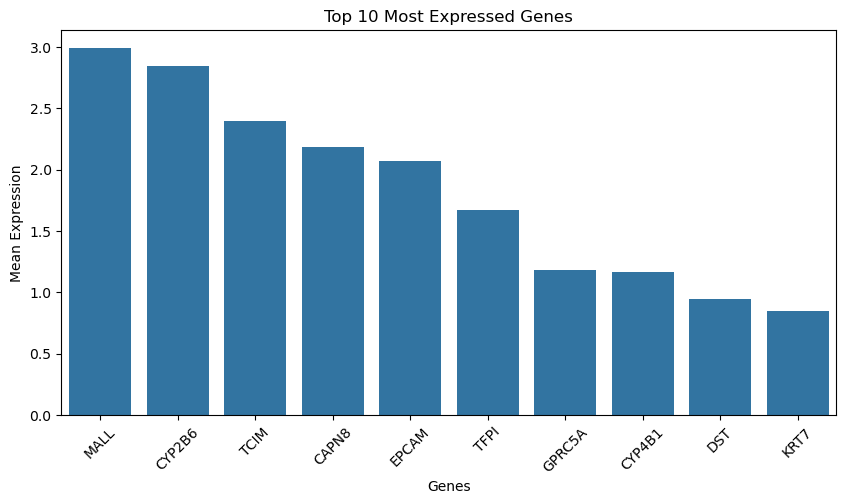

In [6]:
#calculate mean expression for each gene
mean_expression = adata.X.mean(axis=0).A1
top_genes_idx = mean_expression.argsort()[::-1][:10]
top_genes = adata.var_names[top_genes_idx]
top_expression = mean_expression[top_genes_idx]
plt.figure(figsize=(10, 5))
sns.barplot(x=top_genes, y=top_expression)
plt.xlabel("Genes")
plt.ylabel("Mean Expression")
plt.title("Top 10 Most Expressed Genes")
plt.xticks(rotation=45)
plt.show()

We can also look into the distributions of cell and nucleus areas to assess segmentation quality and examine cell size diversity across the dataset. These distributions provide an overview of the range of cell and nucleus sizes, helping to identify segmentation artifacts or inconsistencies, such as unusually small areas (which may indicate partial cells or segmentation errors) or large areas (potentially indicating doublets or merged cells).

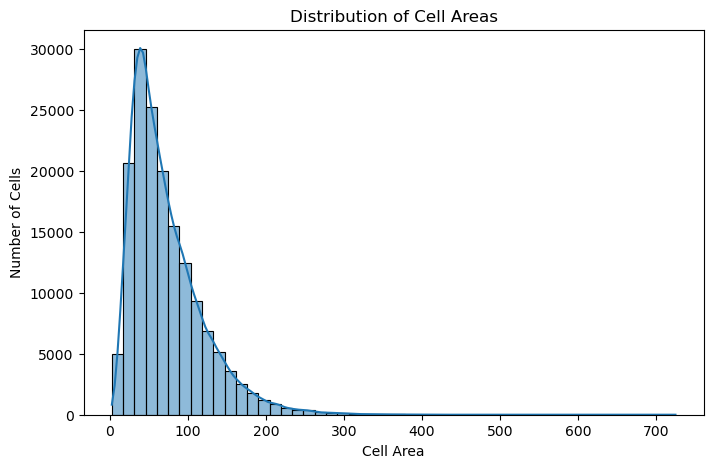

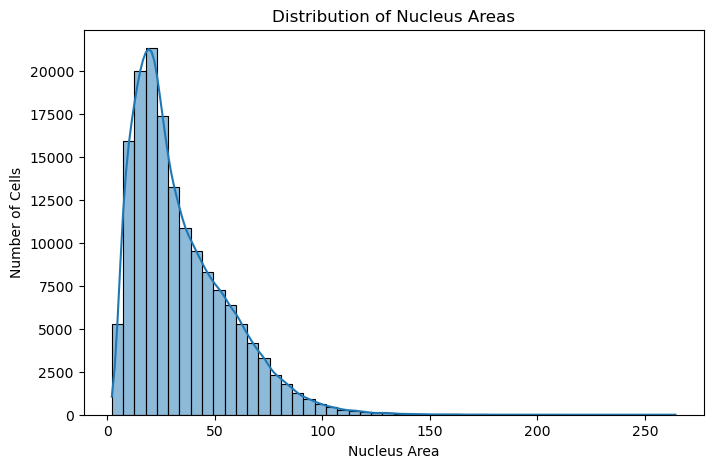

In [7]:
#distribution of cell and nucleus areas
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['cell_area'], kde=True, bins=50)
plt.xlabel("Cell Area")
plt.ylabel("Number of Cells")
plt.title("Distribution of Cell Areas")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['nucleus_area'], kde=True, bins=50)
plt.xlabel("Nucleus Area")
plt.ylabel("Number of Cells")
plt.title("Distribution of Nucleus Areas")
plt.show()

Cell Area vs Nucleus Area

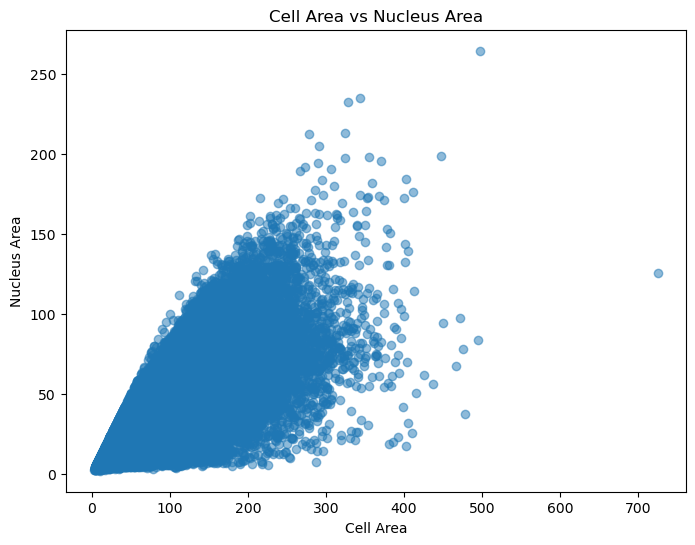

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(adata.obs['cell_area'], adata.obs['nucleus_area'], alpha=0.5)
plt.xlabel("Cell Area")
plt.ylabel("Nucleus Area")
plt.title("Cell Area vs Nucleus Area")
plt.show()

Calculate cell-to-nucleus area ratio and plot it. This ratio provides a measure of the relative size of the nucleus compared to the whole cell, which can be informative for understanding cell morphology and the distribution of nuclear material within cells. A high ratio may indicate cells with large nuclei relative to their overall size, which could be relevant for cell type classification or biological interpretation. Examining this ratio helps identify potential outliers or unusual cell morphologies that may require further investigation or filtering.

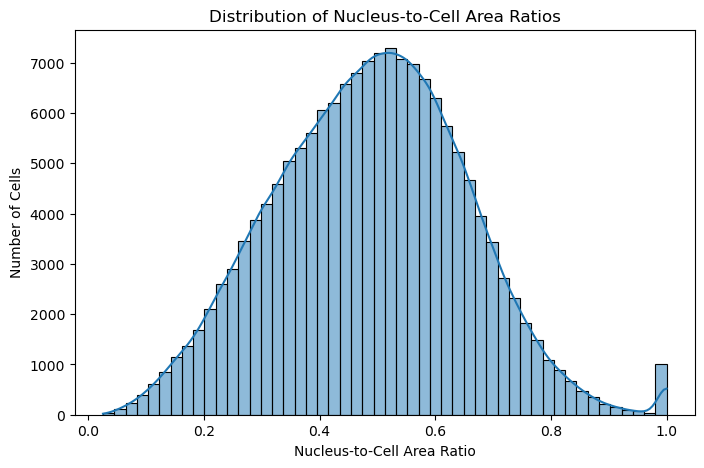

In [9]:
adata.obs['area_ratio'] = adata.obs['nucleus_area'] / adata.obs['cell_area']
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['area_ratio'], kde=True, bins=50)
plt.xlabel("Nucleus-to-Cell Area Ratio")
plt.ylabel("Number of Cells")
plt.title("Distribution of Nucleus-to-Cell Area Ratios")
plt.show()

Scatter plot of Cell Area vs Total Counts


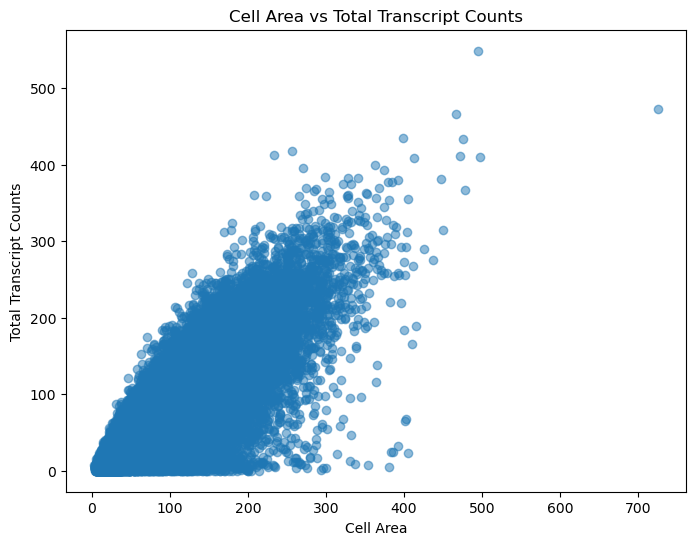

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(adata.obs['cell_area'], adata.obs['total_counts'], alpha=0.5)
plt.xlabel("Cell Area")
plt.ylabel("Total Transcript Counts")
plt.title("Cell Area vs Total Transcript Counts")
plt.show()

Spatial plot of cell and nucleus areas.  

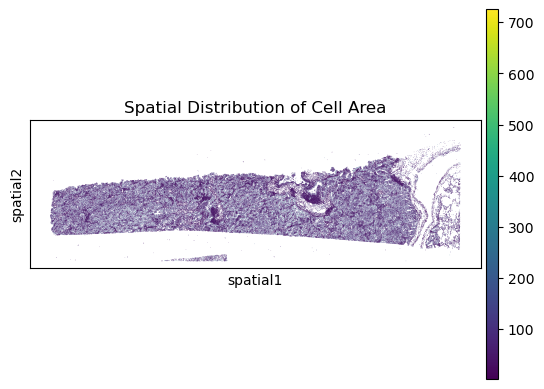

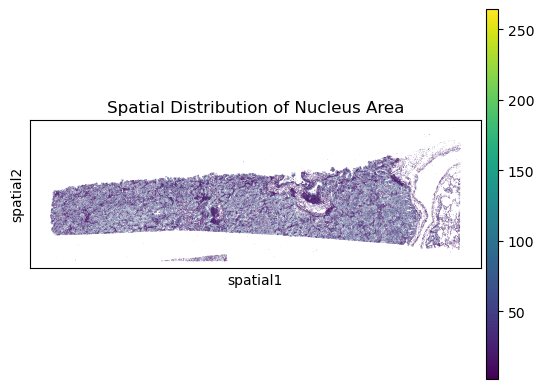

In [11]:
# Spatial plot of cell area
sc.pl.spatial(adata, color='cell_area', spot_size=10, title="Spatial Distribution of Cell Area")

# Spatial plot of nucleus area (if available)
sc.pl.spatial(adata, color='nucleus_area', spot_size=10, title="Spatial Distribution of Nucleus Area")

Looking to spatial distibution of one of the genes. For example the gene "MALL"

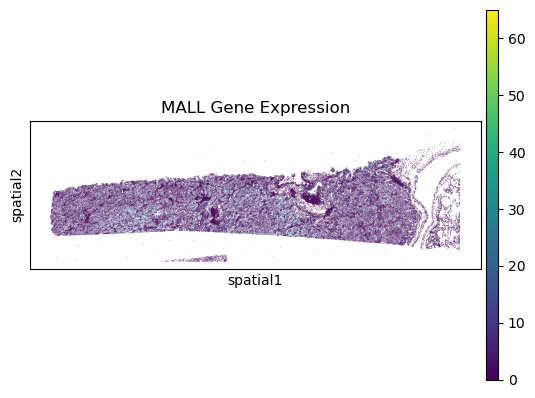

In [12]:
sc.pl.spatial(adata, color=['MALL'], spot_size=10, title="MALL Gene Expression")

In [13]:
# Filter cells with nucleus area < 5
initial_cells_count = adata.n_obs
adata = adata[adata.obs['nucleus_area'] >= 5].copy()
filtered_cells_count = adata.n_obs
print(f"Filtered out {initial_cells_count - filtered_cells_count} cells with nucleus_area < 5. Remaining cells: {filtered_cells_count}")

Filtered out 6241 cells with nucleus_area < 5. Remaining cells: 156013


Plot distribution of total transcript counts per cell and distribution of Nucleus area after filtering

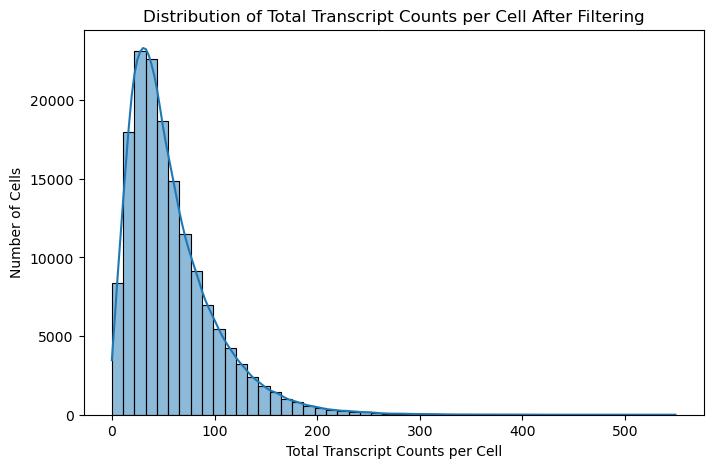

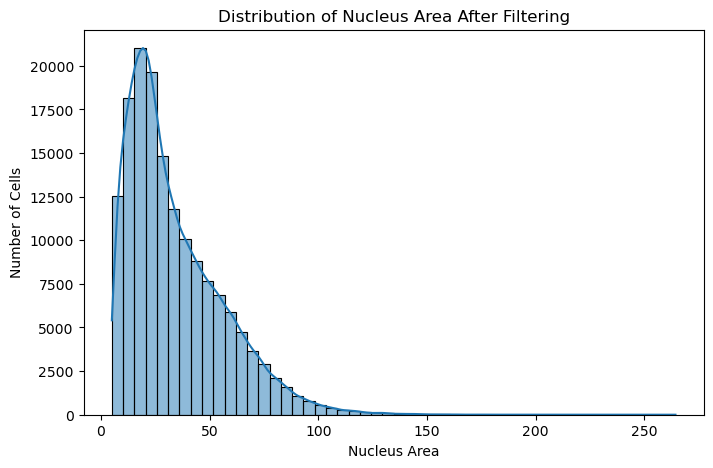

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['total_counts'], kde=True, bins=50)
plt.xlabel("Total Transcript Counts per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Transcript Counts per Cell After Filtering")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['nucleus_area'], kde=True, bins=50)
plt.xlabel("Nucleus Area")
plt.ylabel("Number of Cells")
plt.title("Distribution of Nucleus Area After Filtering")
plt.show()

we can also look into the control probe counts and their spatial distribution to assess background noise and technical quality in the dataset. First, we plot the distribution of control probe counts across cells to understand how frequently control probes are detected. This distribution provides insights into potential technical noise or background signals, as higher-than-expected control counts may suggest artifacts or contamination. Next, we create a spatial plot of control probe counts, which allows us to see if any regions in the tissue exhibit unexpectedly high control counts, possibly indicating localized technical issues.

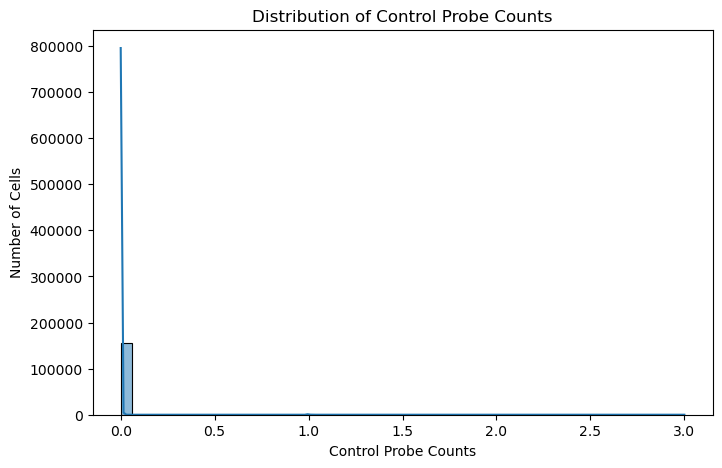

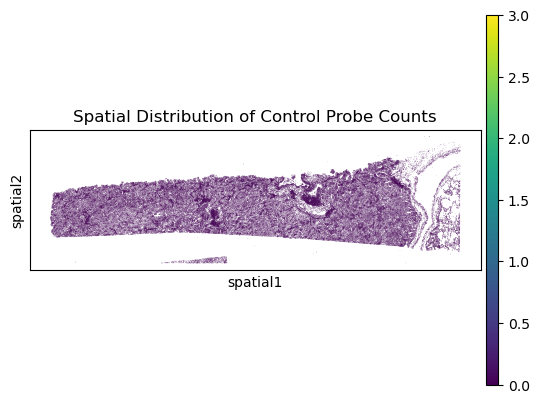

In [15]:
# Plot distribution of control probe counts
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['control_probe_counts'], kde=True, bins=50)
plt.xlabel("Control Probe Counts")
plt.ylabel("Number of Cells")
plt.title("Distribution of Control Probe Counts")
plt.show()

# Spatial plot of control probe counts
sc.pl.spatial(adata, color='control_probe_counts', spot_size=10, title="Spatial Distribution of Control Probe Counts")

## Filtering, Normalizing and Cleaning data

Filter out the cells that have nuclei smaller than 7 microns.

What do you think could be a good cutoff for filtering out lowly expressed genes and cells with low transcript count?
Lets removes low-quality cells and genes from the dataset, which helps reduce noise and computational load in downstream analyses. This filtering step ensures that the dataset is focused on cells and genes with a minimum level of expression, which are more likely to be biologically relevant.

In [16]:
# Cell and gene filtering
initial_cells_count = adata.n_obs
initial_genes_count = adata.n_vars

sc.pp.filter_cells(adata, min_counts=10, inplace=True)
sc.pp.filter_genes(adata, min_cells=5, inplace=True)

filtered_cells_count = adata.n_obs
filtered_genes_count = adata.n_vars
print(f"Filtered {initial_cells_count - filtered_cells_count} (out of intial {initial_cells_count} cells)")
print(f"Filtered {initial_genes_count - filtered_genes_count} (out of intial {initial_genes_count} genes)")

Filtered 7137 (out of intial 156013 cells)
Filtered 0 (out of intial 377 genes)


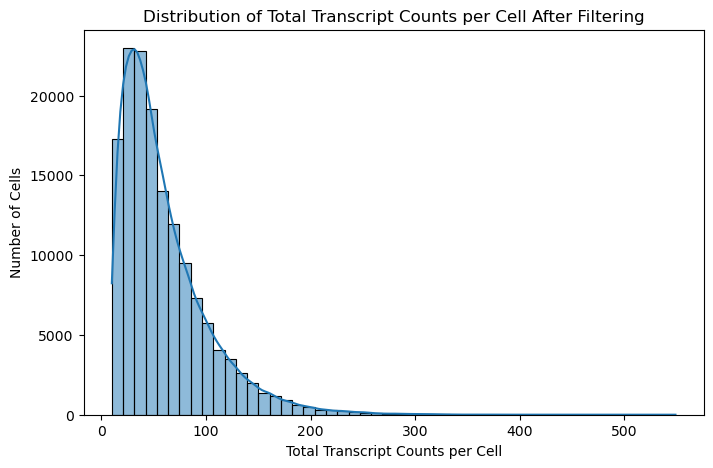

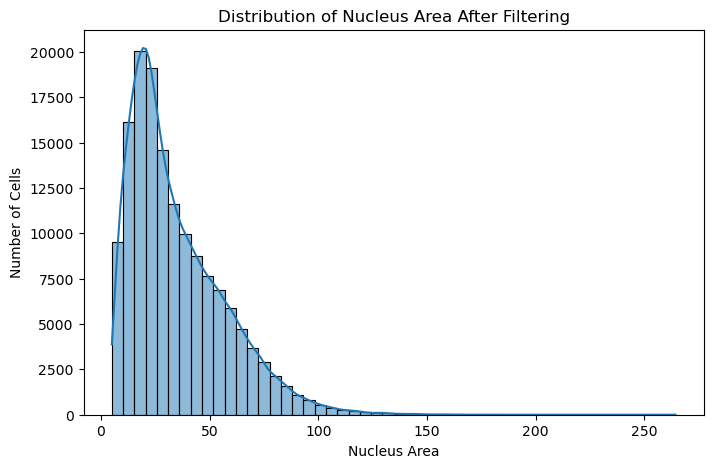

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['total_counts'], kde=True, bins=50)
plt.xlabel("Total Transcript Counts per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Transcript Counts per Cell After Filtering")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(adata.obs['nucleus_area'], kde=True, bins=50)
plt.xlabel("Nucleus Area")
plt.ylabel("Number of Cells")
plt.title("Distribution of Nucleus Area After Filtering")
plt.show()

## Normaliation and scaling
Normalization adjusts for cell-specific technical differences, and log transformation makes the data easier to analyze by reducing the effects of extreme values.
This normalization and transformation make the dataset more appropriate for dimensionality reduction, clustering, and other analyses.

In [18]:
adata.raw = adata.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Comparing the effect of normalization

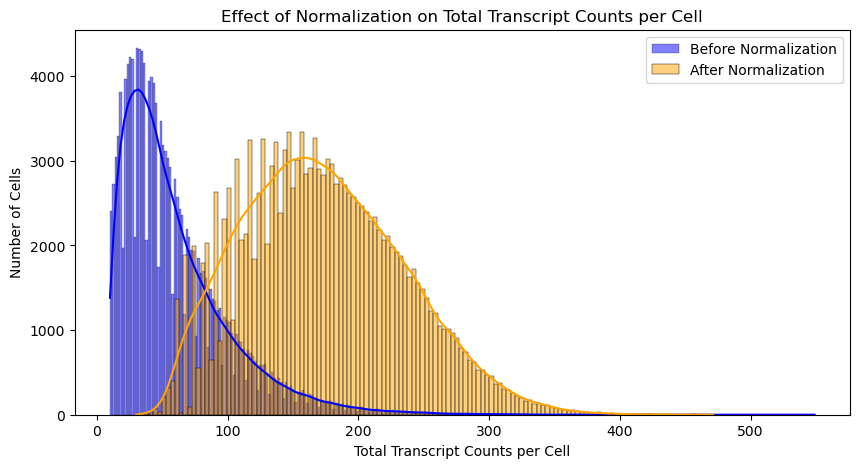

In [ ]:
original_counts = adata.raw.X.sum(axis=1)
normalized_counts = adata.X.sum(axis=1)
#plt distributions
plt.figure(figsize=(10, 5))
sns.histplot(original_counts.A1, color="blue", label="Before Normalization", kde=True) 
sns.histplot(normalized_counts.A1, color="orange", label="After Normalization", kde=True)
plt.xlabel("Total Transcript Counts per Cell")
plt.ylabel("Number of Cells")
plt.title("Effect of Normalization on Total Transcript Counts per Cell")
plt.legend()
plt.show()

How the normalization and scaling of the data affects the distribution of gene expression values in the dataset. We can have a look at the distribution of gene expression values before and after normalization and scaling for MALL gene.

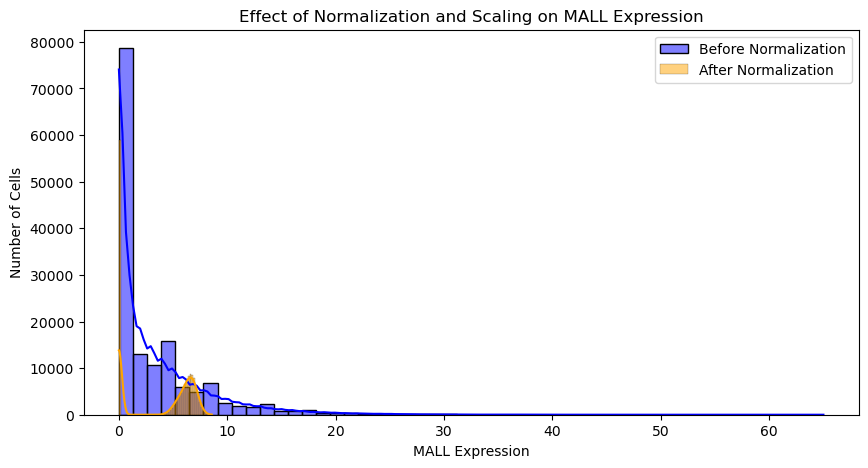

In [20]:
gene_name = "MALL"
if gene_name in adata.var_names:
    # Extract MALL expression values before normalization
    original_mall_expression = adata.raw[:, gene_name].X.toarray().flatten()  # Use `.toarray()` for sparse matrices

    # Extract MALL expression values after normalization
    normalized_mall_expression = adata[:, gene_name].X.toarray().flatten()  # Use `.toarray()` for sparse matrices

    # Plot distributions
    plt.figure(figsize=(10, 5))
    sns.histplot(original_mall_expression, color="blue", label="Before Normalization", kde=True, bins=50)
    sns.histplot(normalized_mall_expression, color="orange", label="After Normalization", kde=True, bins=50)
    plt.xlabel(f"{gene_name} Expression")
    plt.ylabel("Number of Cells")
    plt.title(f"Effect of Normalization and Scaling on {gene_name} Expression")
    plt.legend()
    plt.show()

## Dimensionality reduction

We use dimensionality reduction, clustering, and visualization techniques to analyze the structure of our dataset, group similar cells, and visualize their relationships. First, we apply Principal Component Analysis (PCA) to reduce the high-dimensional gene expression data into a smaller set of principal components, retaining the main patterns of variation while reducing noise. Then, we create a neighbors graph, which identifies connections between cells based on their similarity in the reduced PCA space, capturing local relationships essential for clustering. Using the Leiden clustering algorithm, we group cells into clusters based on these connections, allowing us to identify groups of similar cells that may represent distinct cell types or states. We then apply UMAP (Uniform Manifold Approximation and Projection), a technique that reduces the data to two dimensions for visualization, preserving both local and global structures in the data. Finally, we generate a UMAP plot with cells colored by their assigned clusters, providing an overview of the dataset's structure and making it easy to spot distinct cell populations or clusters. This visualization gives us an interpretable view of the relationships within our data, helping us understand its organization before further analysis.

/Users/rasools/miniconda3/envs/imaging_based_data_analysis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/8l/yj6nz8296zd7wwj0xy6pw3880000gn/T/ipykernel_60411/2991834093.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


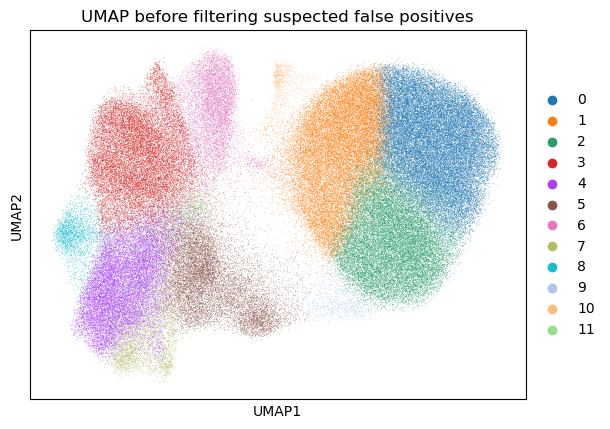

In [22]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', title='UMAP before filtering suspected false positives')

## Systematic Filtering of Suspected False Positives
In Xenium data, some genes may appear to be "expressed" across large areas or in many cells due to background noise or technical artifacts, rather than true biological expression. To address this, we are implementing a gene-specific filtering approach to identify and remove suspected false positives systematically. By filtering out these spurious signals, we can focus our analysis on more reliable gene expression patterns, improving the quality of downstream analyses.

#### 1- Calculate the Mean Expression per Gene per Cluster
In the first step, we calculate the mean expression of each gene within each cluster. Clustering organizes cells into groups that likely share biological characteristics, and taking the average expression of each gene within clusters provides a baseline for typical expression levels. This allows us to identify clusters where a gene has unusually low expression, which might indicate noise rather than true expression.

In [23]:
mean_expression = adata.to_df().groupby(adata.obs['leiden']).mean()

/var/folders/8l/yj6nz8296zd7wwj0xy6pw3880000gn/T/ipykernel_60411/2069805196.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression = adata.to_df().groupby(adata.obs['leiden']).mean()


#### 2- Determine the Maximum Expression Level of Each Gene Across Clusters
Then, we find the maximum expression level for each gene across all clusters. This maximum value serves as a reference point for each gene’s typical expression level in the dataset. The highest expression level of each gene is assumed to represent meaningful expression, while lower values may be more likely to represent noise or background.

In [24]:
max_expression_levels = mean_expression.max(axis=0)

#### 3- Calculate Spurious Expression Threshold for Each Gene
We define a threshold, here set at 5%, which will be used to identify potential false positives. This threshold means that if a gene's expression in a given cluster is below 5% of its highest expression level across all clusters, we will consider it to be a likely false positive. This step allows us to systematically identify clusters where the gene's expression is likely due to background noise rather than true biological signal. Then, we calculate a `spurious expression threshold` for each gene, which is 5% of its maximum expression level. This threshold provides a cut-off below which we consider expression values to be suspected false positives. By applying this threshold, we can filter out clusters where a gene’s expression level is unlikely to be biologically meaningful.

In [25]:
threshold = 0.05
spurious_expression_threshold = max_expression_levels * threshold

#### 4- Identify Suspected False Positives for Each Cluster and Gene
Next we creat a dictionary, `suspected_false_positives`, to store suspected false positive genes for each cluster.
For each cluster, it checks each gene’s mean expression level within that cluster. If the gene's mean expression is below the spurious expression threshold (5% of its maximum expression), the gene is flagged as a suspected false positive in that cluster.

In [ ]:
suspected_false_positives = {}
for cluster in mean_expression.index:
    suspected_genes = []
    for gene in adata.var_names:
        if mean_expression.at[cluster, gene] < spurious_expression_threshold[gene]:
            suspected_genes.append(gene)
    suspected_false_positives[cluster] = suspected_genes

Now we can see a quick summary of the suspected false positives across clusters

Cluster 0 has 22 suspected false positive genes: ['ADGRL4', 'C1orf194', 'C20orf85', 'C6orf118', 'C7', 'CCDC39', 'CCL19', 'CD27', 'CD79A', 'CLEC14A']
Cluster 1 has 67 suspected false positive genes: ['ACKR1', 'ADGRL4', 'ANGPT2', 'ASPN', 'BTNL9', 'C1orf194', 'C20orf85', 'C6orf118', 'C7', 'CCDC39']
Cluster 2 has 27 suspected false positive genes: ['ACKR1', 'ADGRL4', 'ANGPT2', 'C1orf194', 'C20orf85', 'C6orf118', 'C7', 'CCDC39', 'CCL19', 'CD2']
Cluster 3 has 33 suspected false positive genes: ['ACE2', 'AGR3', 'AQP9', 'C1orf194', 'C20orf85', 'C6orf118', 'CCDC39', 'CCDC78', 'CFAP53', 'COL17A1']
Cluster 4 has 56 suspected false positive genes: ['ACE2', 'AGR3', 'ARFGEF3', 'BASP1', 'C1orf194', 'C20orf85', 'C6orf118', 'CAPN8', 'CCDC39', 'CCDC78']
Cluster 5 has 31 suspected false positive genes: ['BTNL9', 'C1orf194', 'C20orf85', 'C6orf118', 'CA4', 'CCDC39', 'CCDC78', 'CFAP53', 'CLEC14A', 'CLIC6']
Cluster 6 has 39 suspected false positive genes: ['ACE2', 'AGR3', 'ANPEP', 'C1orf194', 'C20orf85', 'C6

/var/folders/8l/yj6nz8296zd7wwj0xy6pw3880000gn/T/ipykernel_60411/3901056732.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clusters, y=counts, palette='viridis')


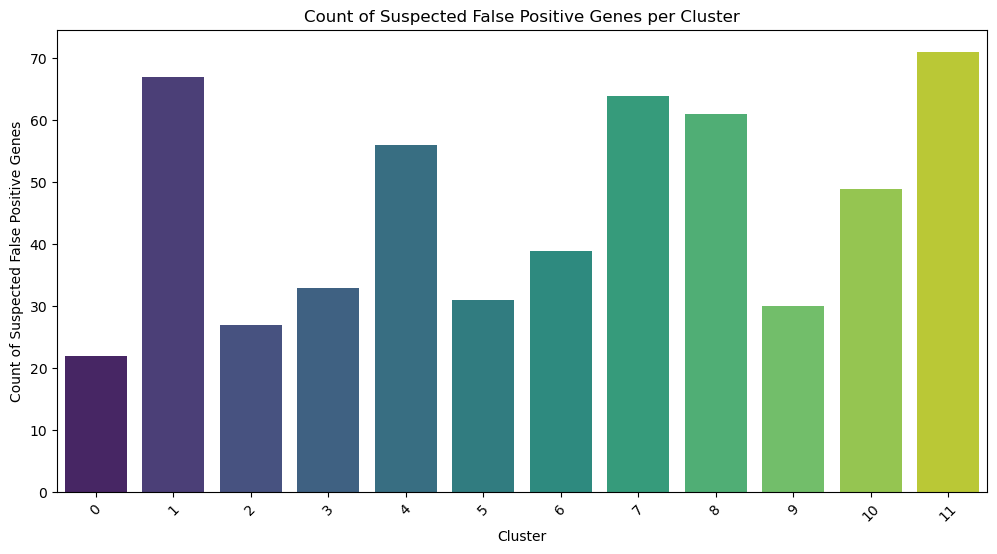

In [ ]:
#Showing first 10 genes for brevity
for cluster, genes in suspected_false_positives.items():
    print(f"Cluster {cluster} has {len(genes)} suspected false positive genes: {genes[:10]}")

cluster_counts = {cluster: len(genes) for cluster, genes in suspected_false_positives.items()}
clusters = list(cluster_counts.keys())
counts = list(cluster_counts.values())
plt.figure(figsize=(12, 6))
sns.barplot(x=clusters, y=counts, palette='viridis')
plt.title('Count of Suspected False Positive Genes per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of Suspected False Positive Genes')
plt.xticks(rotation=45)
plt.show()


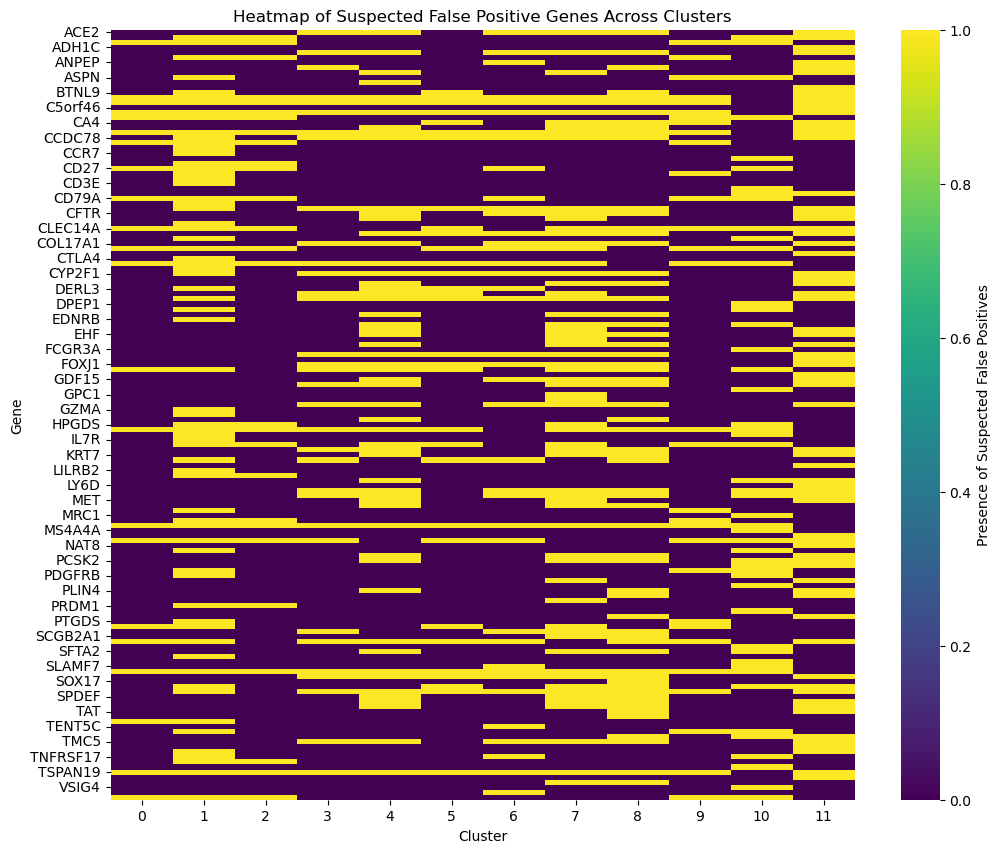

In [28]:
all_suspected_fp_genes = set()
for genes in suspected_false_positives.values():
    all_suspected_fp_genes.update(genes)
all_suspected_fp_genes_list = sorted(all_suspected_fp_genes)
clusters = list(suspected_false_positives.keys())
heatmap_data = pd.DataFrame(0, index=list(all_suspected_fp_genes_list), columns=clusters)

for cluster, genes in suspected_false_positives.items():
    heatmap_data.loc[genes, cluster] = 1

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={'label': 'Presence of Suspected False Positives'})
plt.title("Heatmap of Suspected False Positive Genes Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Gene")
plt.show()

In [ ]:
background_noise_counts = {gene: 0 for gene in adata.var_names}
for gene in adata.var_names:
    for cluster in mean_expression.index:
        if mean_expression.at[cluster, gene] < spurious_expression_threshold[gene]:
            background_noise_counts[gene] += 1

# Find the gene with the highest background noise
highest_noise_gene = max(background_noise_counts, key=background_noise_counts.get)
highest_noise_count = background_noise_counts[highest_noise_gene]

print(f"The gene with the highest background noise is '{highest_noise_gene}', detected below the threshold in {highest_noise_count} clusters.")


The gene with the highest background noise is 'C1orf194', detected below the threshold in 11 clusters.


#### 5- Adjusting gene expression values across the dataset (background noise reduction)
Now, we aim to reduce background noise by adjusting gene expression levels across all cells based on suspected false positives. Specifically, if a gene has low expression (below the spurious expression threshold) in any cluster, we take the highest of those low expression levels and subtract it from all cells for that gene. This method removes unspecific, potentially spurious expression, which can help improve cluster separation and make biologically relevant expression patterns clearer.

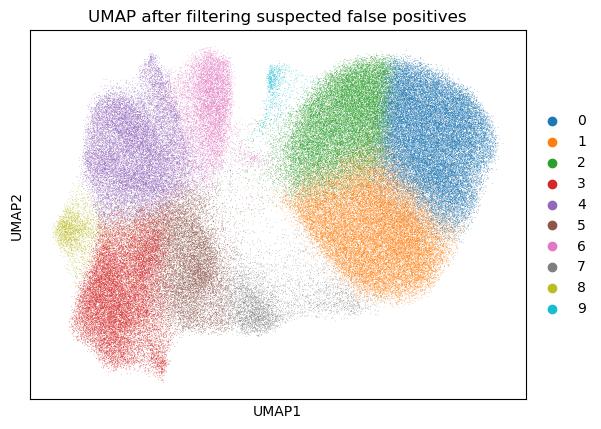

In [30]:
adata_app_1 = adata.copy()

max_filtered_expression = {}
adata_df = adata_app_1.to_df()

for gene in adata_app_1.var_names:
    below_threshold_values = []
    for cluster in mean_expression.index:
        expression_level = mean_expression.at[cluster, gene]
        if expression_level < spurious_expression_threshold[gene]:
            below_threshold_values.append(expression_level)
            
    if below_threshold_values:
        max_filtered_expression[gene] = max(below_threshold_values)
    else:
        max_filtered_expression[gene] = 0  
        #no values below threshold = no subtraction needed

#subtract the maximum filtered expression value from all cells for each gene
for gene in adata_app_1.var_names:
    max_expr = max_filtered_expression[gene]
    if max_expr > 0:
        adata_df[gene] -= max_expr
        #ensure that no negative values are introduced
        adata_df[gene] = np.maximum(adata_df[gene], 0)

#update AnnData object with adjusted gene expressions
adata_app_1 = sc.AnnData(X=adata_df.values, obs=adata_app_1.obs, var=adata_app_1.var, obsm=adata_app_1.obsm)
sc.pp.pca(adata_app_1)
sc.pp.neighbors(adata_app_1)
sc.tl.leiden(adata_app_1)
sc.tl.umap(adata_app_1)
sc.pl.umap(adata_app_1, color='leiden', title='UMAP after filtering suspected false positives')

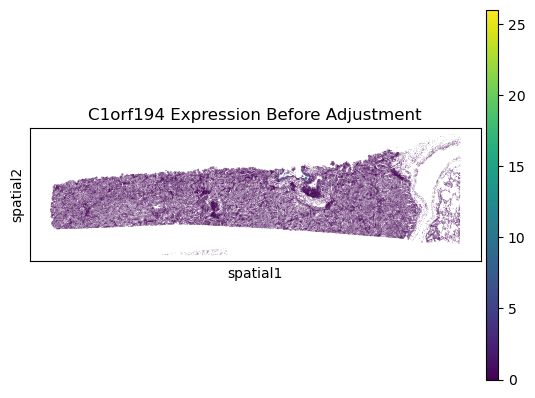

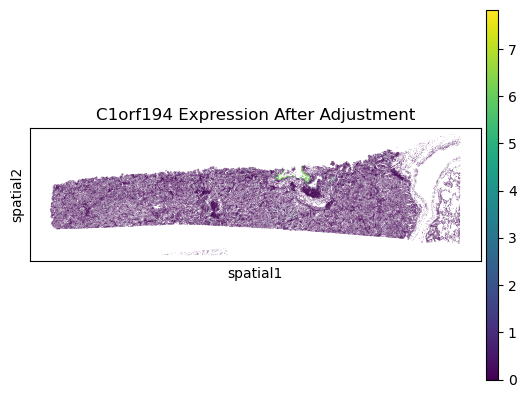

In [31]:
gene_of_interest = "C1orf194"
sc.pl.spatial(adata, color=[gene_of_interest], spot_size=10, title=f'{gene_of_interest} Expression Before Adjustment')
sc.pl.spatial(adata_app_1, color=[gene_of_interest], spot_size=10, title=f'{gene_of_interest} Expression After Adjustment')

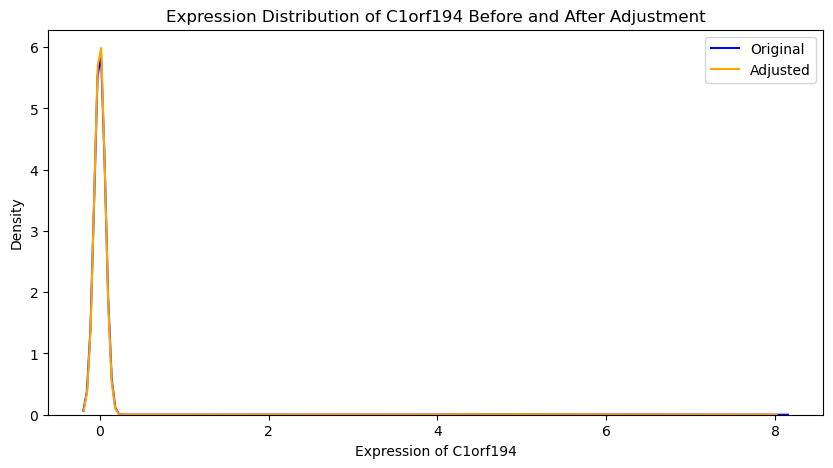

In [32]:
original_expression = adata.to_df()[gene_of_interest]
adjusted_expression = adata_app_1.to_df()[gene_of_interest]

plt.figure(figsize=(10, 5))
sns.kdeplot(original_expression, label="Original", color="blue")
sns.kdeplot(adjusted_expression, label="Adjusted", color="orange")
plt.xlabel(f'Expression of {gene_of_interest}')
plt.ylabel('Density')
plt.title(f'Expression Distribution of {gene_of_interest} Before and After Adjustment')
plt.legend()
plt.show()

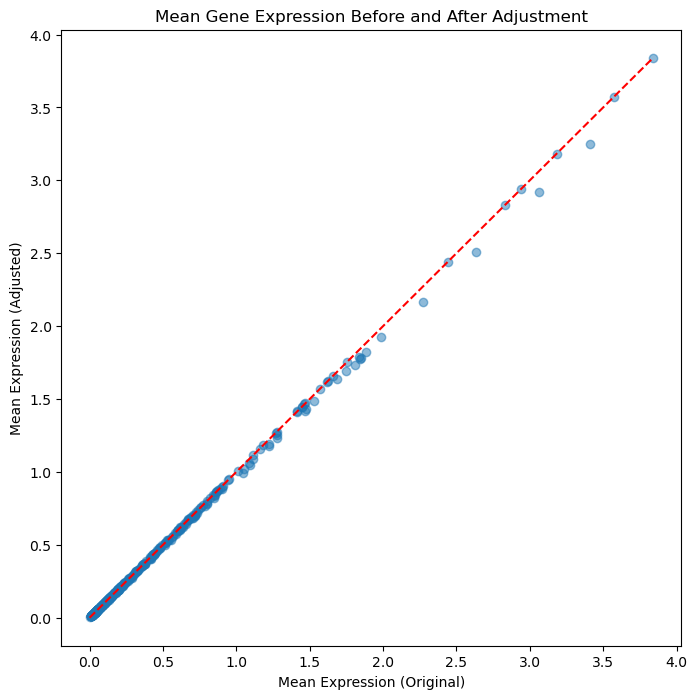

In [33]:
# Calculate mean expression per gene
mean_expression_original = adata.to_df().mean(axis=0)
mean_expression_adjusted = adata_app_1.to_df().mean(axis=0)

# Plot a scatter plot comparing mean expression before and after adjustment
plt.figure(figsize=(8, 8))
plt.scatter(mean_expression_original, mean_expression_adjusted, alpha=0.5)
plt.plot([0, max(mean_expression_original)], [0, max(mean_expression_adjusted)], color="red", linestyle="--")
plt.xlabel('Mean Expression (Original)')
plt.ylabel('Mean Expression (Adjusted)')
plt.title('Mean Gene Expression Before and After Adjustment')
plt.show()

### Second approach
Check the histogram of the gene expression for every gene and if it has a multimodal expression distribution to set based on that histogram a thereshold below which we consider the expression to be background. And we could remove from all cells the expression below that therahold.
First making helper functions performing dip test and plotting the histogram of the gene expression.
I've used dip test to check if the distribution is multimodal or not. If the p-value is smaller than 0.05 we consider the distribution to be multimodal.
A question here would be that should we only consider non-zero expression values for this analysis or should we consider all expression values? If consider all values we might get a multimodal distribution all for genes, however if we only consider non-zero values we might miss some genes that are suspected to have multimodal distribution. What do you think?

In [ ]:
genes_to_analyze = adata.var_names[0:len(adata.var_names)]
thresholds = {}
for gene in genes_to_analyze:
    threshold = hf.analyze_gene_expressions(adata, gene, bandwidth=0.05, plot=False, filter_zeros=False)
    if threshold is not None:
        thresholds[gene] = threshold

Sort genes by threshold values in descending order and display the top genes with the highest thresholds


In [ ]:
sorted_thresholds = sorted(thresholds.items(), key=lambda x: x[1], reverse=True)
print("Top genes with the highest thresholds:")
for gene, threshold_value in sorted_thresholds[:10]:
    print(f"{gene}: {threshold_value}")

In [ ]:
gene_of_interest = "CYP2B6"
hf.analyze_gene_expressions(adata, gene_of_interest, bandwidth=0.05, plot=True, filter_zeros=False)

Now we can do the subtraction of genes with a background expression from their original values in each cell.

In [ ]:
# 1. Reverse the log1p transformation on adata.X
adata_app_2 = adata.copy()
if sp.issparse(adata_app_2.X):
    adata_app_2.X = sp.csr_matrix(np.expm1(adata_app_2.X.toarray()))
else:
    adata_app_2.X = np.expm1(adata_app_2.X)

# 2. Reverse the log1p transformation on thresholds
thresholds = {gene: np.expm1(thresh) for gene, thresh in thresholds.items()}

# 3. Perform the subtraction and ensure non-negative values
for gene, threshold in thresholds.items():
    if gene in adata_app_2.var_names:  # Ensure the gene exists in adata
        gene_index = adata_app_2.var_names.get_loc(gene)
        
        # Extract the column as a dense numpy array
        gene_data = adata_app_2[:, gene].X
        if sp.issparse(gene_data):
            gene_data = gene_data.toarray().flatten()

        # Perform the subtraction and ensure non-negative values
        updated_gene_data = np.maximum(gene_data - threshold, 0)

        # Update the AnnData object
        if sp.issparse(adata_app_2.X):
            adata_app_2[:, gene_index].X = sp.csr_matrix(updated_gene_data[:, np.newaxis])
        else:
            adata_app_2[:, gene_index].X = updated_gene_data[:, np.newaxis]

# 4. Reapply the log1p transformation
sc.pp.log1p(adata_app_2)

In [ ]:
gene_of_interest = "CYP2B6"

sc.pl.spatial(adata, color=[gene_of_interest], spot_size=10, title=f'{gene_of_interest} Expression Before Adjustment')
sc.pl.spatial(adata_app_2, color=[gene_of_interest], spot_size=10, title=f'{gene_of_interest} Expression After Adjustment')

In [ ]:
original_expression = adata.to_df()[gene_of_interest]
adjusted_expression = adata_app_2.to_df()[gene_of_interest]

# Plot expression distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(original_expression, label="Original", color="blue")
sns.kdeplot(adjusted_expression, label="Adjusted", color="orange")
plt.xlabel(f'Expression of {gene_of_interest}')
plt.ylabel('Density')
plt.title(f'Expression Distribution of {gene_of_interest} Before and After Adjustment')
plt.legend()
plt.show()

In [ ]:
# Principal component analysis for dimension reduction
sc.pp.pca(adata_app_2)
sc.pp.neighbors(adata_app_2)
sc.tl.leiden(adata_app_2)
sc.tl.umap(adata_app_2)
sc.pl.umap(adata_app_2, color='leiden', title='UMAP after filtering suspected false positives (approach 2)')